# 

# Model Selection

In **?@sec-linear-regression** and **?@sec-logistic-regression**, we
included one simple method for model selection, stepwise selection. This
chapter expands upon our model selection tools in R by focusing on
regularized regression. The two packages we cover are **glmnet**
\[@R-glmnet\] and **L0Learn** \[@R-L0Learn\]. These two packages focus
on different types of model regularization.

In [ ]:
library(HDSinRdata)
library(tidyverse)
library(glmnet)
library(L0Learn)

To demonstrate these packages, we use the same motivating example as in
**?@sec-linear-regression**. Recall, that the `NHANESsample` dataset
contains lead, blood pressure, BMI, smoking status, alcohol use, and
demographic variables from NHANES 1999-2018. Our focus is looking at the
association between blood lead levels and systolic blood pressure. We
first create a single systolic blood pressure by averaging across all
measurements. We also transform lead with a log transformation before
dropping variables we want to exclude from our analysis.

In [ ]:
# load in data
data(NHANESsample)

# transform SBP and lead
NHANESsample$SBP <- 
  rowMeans(NHANESsample[c("SBP1", "SBP2", "SBP3", "SBP4")], 
                             na.rm=TRUE)
NHANESsample$LEAD <- log(NHANESsample$LEAD)

# remove variables not to include in the model
nhanes <- NHANESsample %>%
  select(-c(ID, HYP, LEAD_QUANTILE, DBP1, DBP2, DBP3, DBP4,
            SBP1, SBP2, SBP3, SBP4, YEAR)) %>%
  na.omit()

# convert to factors
nhanes$SEX <- factor(nhanes$SEX)
nhanes$RACE <- factor(nhanes$RACE)
nhanes$EDUCATION <- factor(nhanes$EDUCATION)
nhanes$BMI_CAT <- factor(nhanes$BMI_CAT)
nhanes$ALC <- factor(nhanes$ALC)

## Regularized Regression

Suppose we have a numeric data matrix $X \in \mathbb{R}^{n \times p}$
and outcome vector $y \in \mathbb{R}^n$. We let $x_i$ denote the vector
representing the $i$th row of $X$. This corresponds to the $i$th
observation. When we refer to regularized regression, we are referring
to solving the following optimization problem that minimizes the average
loss plus a penalty term.

<span id="eq-reguarlization">$$ 
\min_{ (\beta_0, \beta) \in \mathbb{R}^{p+1}} \frac{1}{n} \sum_{i=1}^n l(y_i, \beta_0 + \beta^T x_i) + \text{Pen}(\beta)
 \qquad(1)$$</span>

The function $l(y_i, \beta_0 + \beta^T x_i)$ represents the loss
function. For linear regression, this corresponds to the squared error
$(y_i - \beta_0 - \beta^T x_i)^2$. For logistic regression, this loss
corresponds to the logistic loss function.

The penalty terms we implement include the following:

-   L0 Norm: $||\beta ||_0 = \sum_{j=1}^p 1(\beta_j \neq 0)$, the number
    of non-zero coefficients,

-   L1 Norm: $||\beta ||_1 = \sum_{j=1}^p |\beta_j|$, the sum of
    absolute values of the coefficients, and

-   Squared L2 Norm: $||\beta ||_2^2 = \sum_{j=1}^p \beta_j^2$, the sum
    of squared coefficients.

## Elastic Net 

We first consider L1 and L2 regularization. In particular, consider the
following penalty term, referred to as elastic net regularization,

$$ 
\lambda \left[ \alpha ||\beta||_1 + (1-\alpha) ||\beta||^2_2 \right],
$$

where $\lambda$ is a complexity parameter and $\alpha$ controls the
balance between the two norms. A model with only L1 regularization
($\alpha = 1$) corresponds to lasso regression while a model with only
L2 regularization ($\alpha=0$) corresponds to ridge regression. Note
that the penalty depends on the scale of $X$ and we typically assume
each column has been standardized.

The **glmnet** package implements elastic net regularization. It assumes
our data are in the form described previously. Therefore, we first
create our numeric data matrix `x` and output vector `y`. Some of our
variables are categorical, so in order to create a numeric matrix we
need to one-hot encode them. We can do so using the `model.matrix()`
function which takes in a formula and a data frame and creates the
corresponding design matrix including creating dummy variables from
factor variables and implementing any transformations. Note that we drop
the first generated column which corresponds to the intercept. The
transformation to our outcome does not impact the result.

In [ ]:
x <- model.matrix(log(SBP) ~ ., nhanes)[, -1]
head(x)

  AGE SEXFemale RACEOther Hispanic RACENon-Hispanic White
1  77         0                  0                      1
2  49         0                  0                      1
3  37         0                  0                      1
4  70         0                  0                      0
5  81         0                  0                      1
6  38         1                  0                      1
  RACENon-Hispanic Black RACEOther Race EDUCATIONHS EDUCATIONMoreThanHS INCOME
1                      0              0           0                   1   5.00
2                      0              0           0                   1   5.00
3                      0              0           0                   1   4.93
4                      0              0           0                   0   1.07
5                      0              0           0                   0   2.67
6                      0              0           0                   1   4.52
  SMOKEQuitSmoke SMOKEStillSmoke      LEA

Our outcome vector corresponds to log transformed systolic blood
pressure.

In [ ]:
y <- log(nhanes$SBP)

The `glmnet()` function fits an elastic net regression model. This
requires us to specify our input matrix `x` and response variable `y`.
Additionally, we can specify the assumed distribution for `y` using the
`family` argument. In our subsequent example, we fit this model with
$\alpha = 1$ and 25 different values of $\lambda$. By default,
`glmnet()` sets $\alpha$ to 1 and creates a grid of 100 different values
of `lambda`. It is also the default to standardize `x`, which we can
turn off by specifying `standardize = FALSE` in our function call.

In [ ]:
mod_lasso <- glmnet(x, y, family = "gaussian", alpha = 1,
                    nlambda = 25)

If we plot the resulting object, we can see the model coefficients for
each resulting model by plotting how the coefficient for each variable
changes with the value of $\lambda$. The `plot()` function by default
plots these against the penalty term but we can also specify to plot
against the $\lambda$ values on the log scale. The `label` argument adds
a label to each line, though these are often hard to read. The numbers
at the top of the plot indicate how many non-zero coefficients were
included in the model for different $\lambda$ values. Read the
documentation `?glmnet` to see the other possible inputs including the
`penalty.factor` and `weights` arguments.

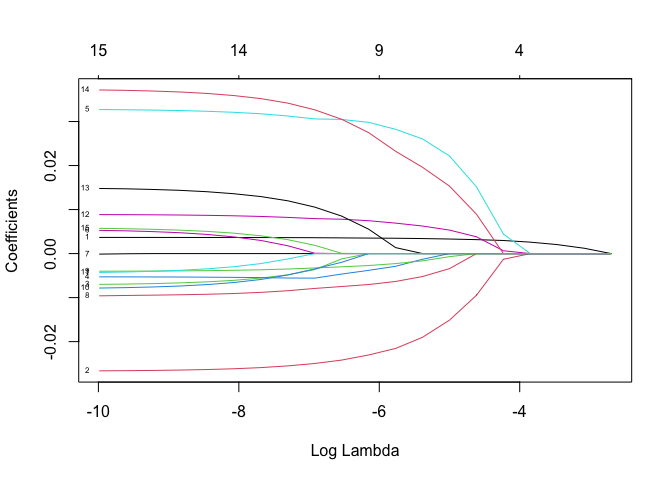

In [ ]:
plot(mod_lasso, xvar = "lambda", label = TRUE)

We can also print our results. This prints a matrix with the values of
$\lambda$ used. For each $\lambda$ value we can also see the number of
non-zero coefficients (`Df`) and the percent deviance explained
(`%dev`).

In [ ]:
print(mod_lasso)


Call:  glmnet(x = x, y = y, family = "gaussian", alpha = 1, nlambda = 25) 

   Df  %Dev   Lambda
1   0  0.00 0.067400
2   1 11.60 0.045920
3   1 16.98 0.031280
4   1 19.48 0.021310
5   4 21.03 0.014520
6   5 23.15 0.009893
7   7 24.34 0.006740
8   8 24.94 0.004592
9   9 25.25 0.003128
10  9 25.45 0.002131
11 12 25.57 0.001452
12 13 25.64 0.000989
13 14 25.69 0.000674
14 14 25.71 0.000459
15 14 25.72 0.000313
16 14 25.72 0.000213
17 14 25.73 0.000145
18 14 25.73 0.000099
19 15 25.73 0.000067
20 15 25.73 0.000046

We can extract the model for a particular value of $\lambda$ using the
`coef()` function. The argument `s` specifies the value of $\lambda$.
For the particular value of $\lambda$ chosen in the following code, only
age has a non-zero coefficient. Note that the `coef()` function returns
the coefficients on the original scale.

In [ ]:
coef(mod_lasso, s = 0.045920)

16 x 1 sparse Matrix of class "dgCMatrix"
                                s1
(Intercept)            4.752405796
AGE                    0.001211976
SEXFemale              .          
RACEOther Hispanic     .          
RACENon-Hispanic White .          
RACENon-Hispanic Black .          
RACEOther Race         .          
EDUCATIONHS            .          
EDUCATIONMoreThanHS    .          
INCOME                 .          
SMOKEQuitSmoke         .          
SMOKEStillSmoke        .          
LEAD                   .          
BMI_CAT25<BMI<30       .          
BMI_CATBMI>=30         .          
ALCYes                 .          

We can also use the `predict()` function to predict blood pressure for
this particular model. In the function call, we have specified our value
of $\lambda$ as well as our data matrix `x` as the data to predict on.

In [ ]:
pred_lasso <- predict(mod_lasso, s = 0.045920, newx = x)

This shows our observed model fit for a fairly high penalty term. In
order to choose the best value of $\lambda$, we use 5-fold
cross-validation. First, we randomly assign each observation to one of
five folds using the `sample()` function. We can see that this splits
the data into folds of roughly equal size.

In [ ]:
set.seed(1)
foldid <- sample(1:5, size = nrow(x), replace = TRUE)
table(foldid)

foldid
   1    2    3    4    5 
6081 5967 6048 6188 6121 

Next, we call the `cv.glmnet()` function which implements k-fold
cross-validation across a grid of $\lambda$ values. Similar to before,
we specified `x`, `y`, and `alpha = 1`. This time, we also include the
measure to use for cross-validation (`mse` indicates mean squared error)
and provide the fold vector `foldid`. If you do not want to provide
folds, you can instead use the `nfolds` argument to specify the number
of folds desired and the `cv.glmnet()` function will create them.
Plotting the returned object shows us the estimated mean squared error
for different values of $\lambda$ as well as error bars for each
estimate. Similar to before, it also shows the number of non-zero
coefficients at the top.

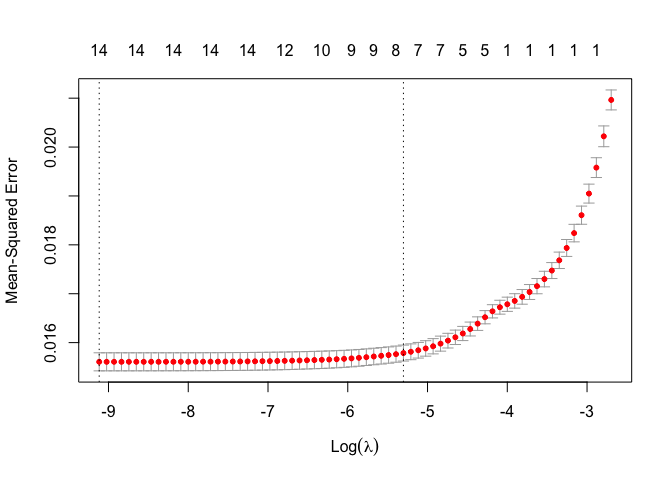

In [ ]:
cv_lasso <- cv.glmnet(x, y, foldid = foldid, alpha = 1,
                      type.measure = "mse")
plot(cv_lasso)

There are two vertical dashed lines included in the plot. These
correspond to two values of $\lambda$ that are stored in our object. The
first is `lambda.min`. This corresponds to the $\lambda$ value with the
lowest estimated mean squared error. The other is `lambda.1se`. This
corresponds to the largest $\lambda$ value whose estimated mean squared
error is within one standard error of the lowest value. As indicated in
the plot, this corresponds to a model with fewer included coefficients
and higher regularization.

We use the `lambda.min` value as our chosen $\lambda$ value. To extract
the coefficients corresponding to this $\lambda$ value we again use the
`coef()` function. However, this $\lambda$ might not be one of the
initial 25 used for our `mod_lasso` object. In this case, the `coef()`
function uses linear interpolation to get the estimated coefficients. If
we want to refit our model for this particular value of $\lambda$, we
can instead specify the argument `exact = TRUE` and provide `x` and `y`.

In [ ]:
lasso_coef <- coef(mod_lasso, s = cv_lasso$lambda.min,
                   exact = TRUE, x = x, y = y)
lasso_coef

16 x 1 sparse Matrix of class "dgCMatrix"
                                 s1
(Intercept)             4.634576140
AGE                     0.003667460
SEXFemale              -0.026521442
RACEOther Hispanic     -0.006773266
RACENon-Hispanic White -0.005309166
RACENon-Hispanic Black  0.032573010
RACEOther Race          0.004932825
EDUCATIONHS             .          
EDUCATIONMoreThanHS    -0.009419653
INCOME                 -0.003958058
SMOKEQuitSmoke         -0.007530578
SMOKEStillSmoke        -0.003972806
LEAD                    0.008798585
BMI_CAT25<BMI<30        0.014521917
BMI_CATBMI>=30          0.036876997
ALCYes                  0.005468538

We now repeat the same process for a model with $\alpha = 0$ and
$\alpha = 0.5$. In this case, we call the `glmnet()` function with our
chosen $\lambda$ value to find the coefficients. This is equivalent to
what we did for our lasso model. Last, we create a data frame with the
estimated coefficients for each model. The `coef()` function returns a
matrix, so this requires converting these to numeric vectors.

In [ ]:
# cross-validation using same folds
cv_ridge <- cv.glmnet(x, y, foldid = foldid, alpha = 0,
                      type.measure = "mse")
cv_elastic <- cv.glmnet(x, y, foldid = foldid, alpha = 0.5,
                      type.measure = "mse")

# Refit model on full data with chosen lambda
mod_ridge <- glmnet(x, y, alpha = 0, lambda = cv_ridge$lambda.min)
mod_elastic <- glmnet(x, y, alpha = 0.5, lambda = cv_ridge$lambda.min)

# extract coefficients for a table
res_coef <- data.frame(name = c("Intercept", colnames(x)),
                       lasso = round(as.numeric(lasso_coef), 3),
                       ridge = round(as.numeric(coef(mod_ridge)), 3),
                       elastic = round(as.numeric(coef(mod_elastic)), 
                                       3))
res_coef

                     name  lasso  ridge elastic
1               Intercept  4.635  4.646   4.650
2                     AGE  0.004  0.003   0.003
3               SEXFemale -0.027 -0.025  -0.020
4      RACEOther Hispanic -0.007 -0.007   0.000
5  RACENon-Hispanic White -0.005 -0.005  -0.002
6  RACENon-Hispanic Black  0.033  0.031   0.027
7          RACEOther Race  0.005  0.004   0.000
8             EDUCATIONHS  0.000  0.000   0.000
9     EDUCATIONMoreThanHS -0.009 -0.010  -0.006
10                 INCOME -0.004 -0.004  -0.002
11         SMOKEQuitSmoke -0.008 -0.006   0.000
12        SMOKEStillSmoke -0.004 -0.005   0.000
13                   LEAD  0.009  0.011   0.008
14       BMI_CAT25<BMI<30  0.015  0.014   0.000
15         BMI_CATBMI>=30  0.037  0.035   0.022
16                 ALCYes  0.005  0.004   0.000

The coefficients between the models are not so different. We can also
compare their mean squared errors, which are also similar. Since our
lasso model was fit on a grid of $\lambda$ values, we again have to
specify this value.

In [ ]:
mean((nhanes$SBP - exp(predict(mod_lasso, newx = x,
                               s = cv_lasso$lambda.min)))^2)

[1] 267.8089

[1] 268.2627

[1] 270.0166

## Best Subset 

The second package we introduce in this chapter is one that allows us to
fit models with an L0 penalty term. The package **L0Learn** considers
penalties of the following forms.

-   L0 only: $\lambda ||\beta||_0$

-   L0L1: $\lambda ||\beta ||_0 + \gamma ||\beta||_1$

-   L0L2: $\lambda ||\beta||_0 + \gamma ||\beta ||_2^2$

To fit a model with an L0 penalty term, we use the `L0Learn.fit()`
function. Similar to `glmnet()`, we need to specify our input matrix `x`
and response vector `y` as well as our penalty using the `penalty`
argument. We can also specify a number of $\lambda$ values to consider
`nLambda` and specify the family through the loss function `loss`.

In [ ]:
mod_l0 <- L0Learn.fit(x, y, penalty = "L0", loss = "SquaredError",
                      nLambda = 20)

Plotting the returned object also shows how the coefficients for each
variable change with the penalty term, given by the support size or
number of non-zero coefficients in this case. We can also print the
returned object to see the different values of $\lambda$ used and the
corresponding number of included variables.

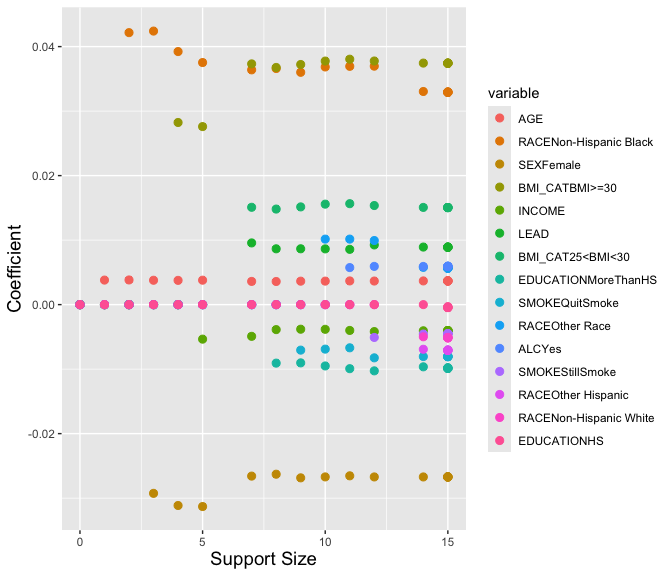

In [ ]:
plot(mod_l0)

In [ ]:
print(mod_l0)

        lambda gamma suppSize
1  1.08234e-01     0        0
2  1.07151e-01     0        1
3  6.50802e-03     0        2
4  4.99955e-03     0        3
5  4.21707e-03     0        4
6  1.75475e-03     0        5
7  5.36069e-04     0        7
8  3.23288e-04     0        8
9  1.91660e-04     0        9
10 1.41789e-04     0       10
11 1.03903e-04     0       11
12 6.79760e-05     0       12
13 1.75448e-05     0       14
14 4.05786e-07     0       15
15 3.93613e-07     0       15
16 3.02582e-08     0       15
17 5.86656e-09     0       15
18 9.43085e-10     0       15
19 3.48045e-10     0       15
20 2.18823e-10     0       15

To extract the model for a particular value, we can use the `coef()`
function and specify the $\lambda$ and $\gamma$ values to use.

In [ ]:
coef_l0 <- coef(mod_l0, lambda = 1.75475e-03, gamma = 0)

Unfortunately, this output doesn’t include variable names so we add them
manually.

In [ ]:
rownames(coef_l0) <- c("Intercept", colnames(x))
coef_l0

16 x 1 sparse Matrix of class "dgCMatrix"
                                   
Intercept               4.638465675
AGE                     0.003787882
SEXFemale              -0.031303070
RACEOther Hispanic      .          
RACENon-Hispanic White  .          
RACENon-Hispanic Black  0.037530153
RACEOther Race          .          
EDUCATIONHS             .          
EDUCATIONMoreThanHS     .          
INCOME                 -0.005352346
SMOKEQuitSmoke          .          
SMOKEStillSmoke         .          
LEAD                    .          
BMI_CAT25<BMI<30        .          
BMI_CATBMI>=30          0.027600301
ALCYes                  .          

If instead we want to include a penalty with an L0 and L2 norm term, we
can change our penalty argument to `penalty = L0L2` and specify a number
of $\gamma$ values to test.

In [ ]:
mod_l0l2 <- L0Learn.fit(x, y, penalty = "L0L2", 
                        loss = "SquaredError",
                        nLambda = 20, nGamma = 10)

The **L0Learn** package also includes a function to use cross-validation
to choose these parameters. Unfortunately, it does not include an option
to specify your own folds. Instead, we use the `nFolds` argument to
specify to run 5-fold cross-validation. This function also allows us to
specify a number of $\lambda$ and $\gamma$ values, or we can use the
default number. Plotting the result shows the estimated mean squared
error with error bars for each model and the corresponding support size.

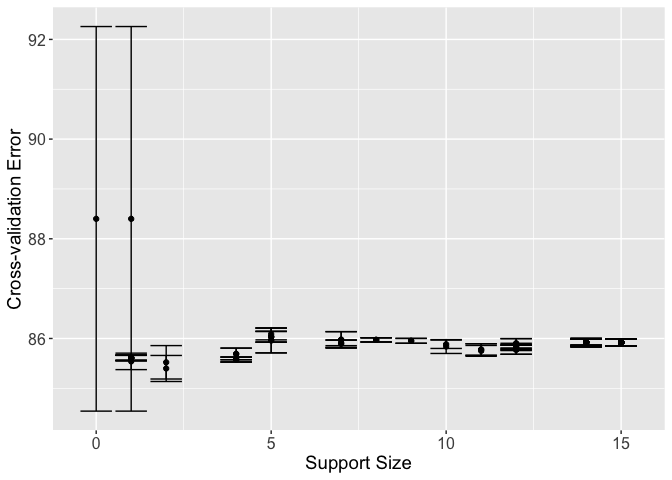

In [ ]:
cv_l0l2 = L0Learn.cvfit(x, y, loss = "SquaredError",
                        nFolds = 5, penalty = "L0L2")
plot(cv_l0l2)

The returned results are stored in `cvMeans`. This is a list of matrices
— one for each value of $\gamma$. To extract these into a more
manageable form, we use the `sapply()` function to convert each matrix
to a numeric vector and create a matrix of results. The columns of this
matrix correspond to the 10 $\gamma$ values used, and each column of
this matrix corresponds to 100 $\lambda$ values chosen for that
particular value of $\gamma$. We use the `which()` function to find
which one has the lowest estimated mean squared error.

In [ ]:
cv_res <- sapply(cv_l0l2$cvMeans, as.numeric)
min_ind <- which(cv_res == min(cv_res), arr.ind = TRUE)
min_ind

     row col
[1,]  11  10

We can then extract out the corresponding $\gamma$ and $\lambda$ values
through the `fit` object returned in our result.

In [ ]:
gamma_min <- cv_l0l2$fit$gamma[[min_ind[2]]]
lambda_min <- cv_l0l2$fit$lambda[[min_ind[2]]][min_ind[1]]

We find the estimated coefficients for this model using the `coef()`
function on the cross-validation object `cv_l0l2`.

In [ ]:
cv_coef_l0 <- coef(cv_l0l2, gamma = gamma_min, lambda = lambda_min)
rownames(cv_coef_l0) <- c("Intercept", colnames(x))
cv_coef_l0

16 x 1 sparse Matrix of class "dgCMatrix"
                                  
Intercept              4.616714644
AGE                    0.003822973
SEXFemale              .          
RACEOther Hispanic     .          
RACENon-Hispanic White .          
RACENon-Hispanic Black 0.042156336
RACEOther Race         .          
EDUCATIONHS            .          
EDUCATIONMoreThanHS    .          
INCOME                 .          
SMOKEQuitSmoke         .          
SMOKEStillSmoke        .          
LEAD                   .          
BMI_CAT25<BMI<30       .          
BMI_CATBMI>=30         .          
ALCYes                 .          

Last, we use the `predict()` function on `cv_l0l2` to evaluate our
resulting model. To do so, we need to specify $\lambda$ and $\gamma$ as
well as our data `x`. This model is much sparser than the ones in the
previous section, but our mean squared error on our training data is a
little higher.

In [ ]:
pred_l0l2 <- predict(cv_l0l2, gamma = gamma_min, 
                     lambda = lambda_min, newx = x)
mean((nhanes$SBP - exp(pred_l0l2))^2)

[1] 274.9735

## Exercises

For these exercises, we use the `nyts` data from
**?@sec-logistic-regression**. Our outcome of interest is whether or not
someone uses any tobacco product.

1.  Create a new variable `tobacco_use` representing any tobacco use in
    the past 30 days (including e-cigarettes, cigarettes, and/or
    cigars). Then, create a new data frame `nyts_sub` that contains this
    new column as well as columns for location, age, sex, race, whether
    someone identifies with the LGBT community, grades in the past year,
    perceived_cigarette use, perceived e-cigarette use, psych distress,
    and family affluence.

2.  Create an outcome vector `y` corresponding to the column
    `tobacco_use` and a model matrix `x` containing all other
    covariates.

3.  Fit a L1 (lasso), L2 (ridge), and L0 (best subset) penalized
    regression model using 5-fold cross-validation. Create a data frame
    with the corresponding coefficients for all models. Be sure to
    update the loss function to reflect our binary outcome.

4.  Report the AUC and accuracy of these three models on the training
    data.